## Generative Adversarial Networks (GANs) in PyTorch


In [4]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
DATA_DIR = '/celebrity-face-image-dataset'

In [3]:
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
    ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

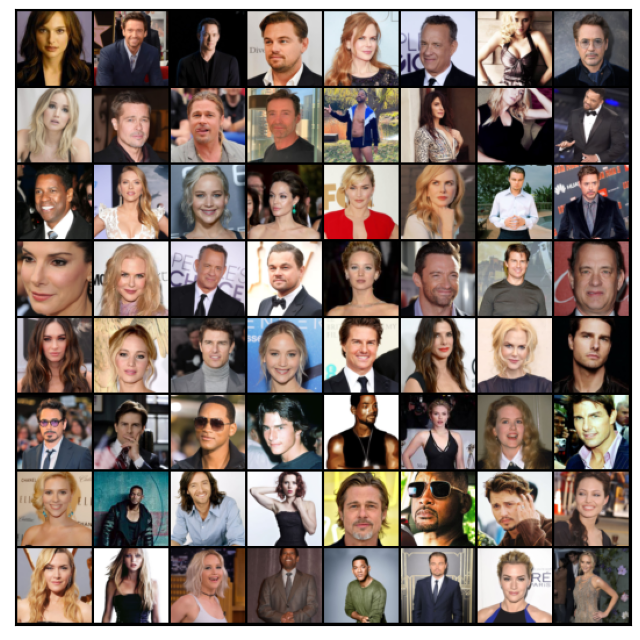

In [8]:
show_batch(train_dl)

## Using a GPU

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## GAN Overview

A generative adversarial network (GAN) has two parts:

* The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
* The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

Here are the steps a GAN takes:

* The generator takes in random numbers and returns an image.
* This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.
* The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

![](https://wiki.pathmind.com/images/wiki/gan_schema.png)

Example:
![](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg)
As training progresses, the generator gets closer to producing output that can fool the discriminator:
![](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg)
![](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg)


## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. I'll use a convolutional neural networks (CNN) which outputs a single number output for every image. I'll use stride of 2 to progressively reduce the size of the output feature map.

Blue maps are inputs, and cyan maps are outputs.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

## Generator Network

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

In ConvTranspose2d network padding and stride happens like below:

![](https://camo.githubusercontent.com/4f47a1960462f9c44776cb98be5fc22538766b0bccc54a772c837f4d98254b27/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3230313339372f32316661666564302d613934392d653539392d656663362d3233343439633036396433632e706e67)

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_transposed.gif)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [17]:
generator = to_device(generator, device)

## Discriminator Training

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [20]:
from torchvision.utils import save_image

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


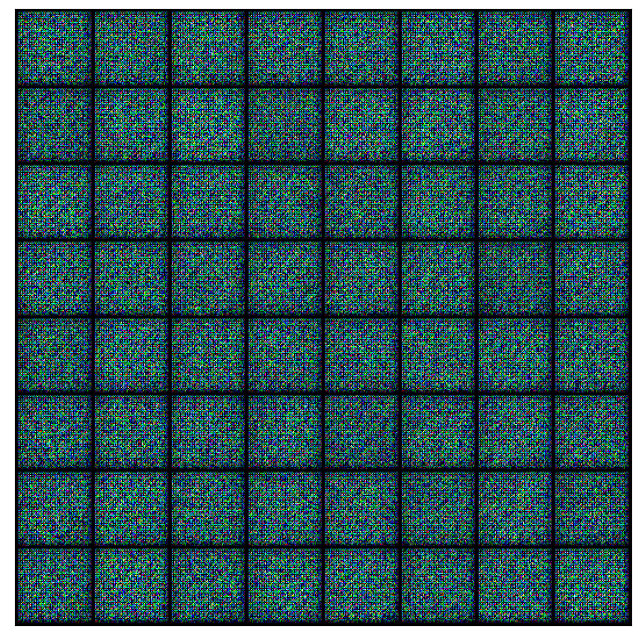

In [24]:
save_samples(0, fixed_latent)

## Full Training Loop

In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
%%time
lr = 0.005
epochs = 400
history = fit(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/400], loss_g: 10.9081, loss_d: 3.6209, real_score: 0.5487, fake_score: 0.4640
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/400], loss_g: 8.9371, loss_d: 0.1680, real_score: 0.8979, fake_score: 0.0044
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/400], loss_g: 2.8250, loss_d: 2.0791, real_score: 0.3653, fake_score: 0.0186
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/400], loss_g: 9.5661, loss_d: 0.3432, real_score: 0.9921, fake_score: 0.2119
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/400], loss_g: 5.2246, loss_d: 10.4022, real_score: 0.0003, fake_score: 0.0001
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/400], loss_g: 3.8156, loss_d: 0.4442, real_score: 0.7212, fake_score: 0.0397
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/400], loss_g: 11.9312, loss_d: 0.0254, real_score: 0.9787, fake_score: 0.0032
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/400], loss_g: 6.7487, loss_d: 0.7568, real_score: 0.9987, fake_score: 0.4084
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/400], loss_g: 6.8475, loss_d: 1.1044, real_score: 0.5597, fake_score: 0.0017
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/400], loss_g: 6.1894, loss_d: 0.0740, real_score: 0.9967, fake_score: 0.0563
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/400], loss_g: 6.0408, loss_d: 1.1741, real_score: 0.7226, fake_score: 0.3495
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/400], loss_g: 6.5306, loss_d: 0.6950, real_score: 0.8121, fake_score: 0.2551
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/400], loss_g: 9.0865, loss_d: 0.9119, real_score: 0.5978, fake_score: 0.0087
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/400], loss_g: 4.3669, loss_d: 4.7838, real_score: 0.9963, fake_score: 0.7999
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/400], loss_g: 4.4280, loss_d: 0.4342, real_score: 0.8137, fake_score: 0.0693
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/400], loss_g: 4.8422, loss_d: 0.4808, real_score: 0.9244, fake_score: 0.2421
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/400], loss_g: 3.5211, loss_d: 1.1900, real_score: 0.5878, fake_score: 0.3271
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/400], loss_g: 1.3586, loss_d: 2.0263, real_score: 0.2909, fake_score: 0.0873
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/400], loss_g: 1.7094, loss_d: 3.5650, real_score: 0.0958, fake_score: 0.0241
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/400], loss_g: 3.7641, loss_d: 1.3834, real_score: 0.7641, fake_score: 0.5134
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/400], loss_g: 4.3076, loss_d: 0.7633, real_score: 0.9080, fake_score: 0.4151
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/400], loss_g: 0.4409, loss_d: 2.0930, real_score: 0.3115, fake_score: 0.1679
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/400], loss_g: 2.8127, loss_d: 1.1663, real_score: 0.6731, fake_score: 0.4452
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/400], loss_g: 4.1645, loss_d: 0.5220, real_score: 0.8053, fake_score: 0.2035
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/400], loss_g: 0.9347, loss_d: 1.8576, real_score: 0.9240, fake_score: 0.7212
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/400], loss_g: 1.0585, loss_d: 1.7909, real_score: 0.4616, fake_score: 0.3520
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/400], loss_g: 2.2149, loss_d: 1.0622, real_score: 0.7206, fake_score: 0.4162
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/400], loss_g: 1.6929, loss_d: 0.7622, real_score: 0.6421, fake_score: 0.2249
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/400], loss_g: 3.4234, loss_d: 0.7312, real_score: 0.7084, fake_score: 0.2785
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/400], loss_g: 1.1725, loss_d: 3.6211, real_score: 0.1785, fake_score: 0.0430
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/400], loss_g: 3.0065, loss_d: 0.6743, real_score: 0.6492, fake_score: 0.1871
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/400], loss_g: 0.8074, loss_d: 3.3145, real_score: 0.0650, fake_score: 0.0870
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/400], loss_g: 2.5867, loss_d: 0.9384, real_score: 0.7744, fake_score: 0.4185
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/400], loss_g: 3.4467, loss_d: 0.9424, real_score: 0.7527, fake_score: 0.3976
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/400], loss_g: 2.0387, loss_d: 1.7080, real_score: 0.5297, fake_score: 0.4487
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/400], loss_g: 3.6569, loss_d: 2.1247, real_score: 0.3102, fake_score: 0.0206
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/400], loss_g: 1.7066, loss_d: 1.5199, real_score: 0.4798, fake_score: 0.3319
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/400], loss_g: 3.4882, loss_d: 0.7885, real_score: 0.8868, fake_score: 0.4241
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/400], loss_g: 5.0810, loss_d: 1.3043, real_score: 0.7561, fake_score: 0.5621
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/400], loss_g: 1.8353, loss_d: 0.9136, real_score: 0.6672, fake_score: 0.3387
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/400], loss_g: 3.1087, loss_d: 0.8276, real_score: 0.7424, fake_score: 0.3308
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/400], loss_g: 1.5386, loss_d: 1.5600, real_score: 0.4423, fake_score: 0.3636
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/400], loss_g: 1.2444, loss_d: 1.4746, real_score: 0.3726, fake_score: 0.0757
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/400], loss_g: 3.5415, loss_d: 1.3379, real_score: 0.7172, fake_score: 0.5375
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/400], loss_g: 4.2090, loss_d: 1.1771, real_score: 0.9635, fake_score: 0.5636
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/400], loss_g: 1.7892, loss_d: 1.4279, real_score: 0.4287, fake_score: 0.1026
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/400], loss_g: 4.1559, loss_d: 1.3089, real_score: 0.8299, fake_score: 0.5845
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/400], loss_g: 2.6328, loss_d: 0.9570, real_score: 0.7177, fake_score: 0.4119
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/400], loss_g: 1.5439, loss_d: 1.3022, real_score: 0.6028, fake_score: 0.4121
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/400], loss_g: 2.4171, loss_d: 1.0005, real_score: 0.5613, fake_score: 0.2083
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/400], loss_g: 1.1950, loss_d: 2.6318, real_score: 0.1376, fake_score: 0.0263
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/400], loss_g: 1.0828, loss_d: 1.1882, real_score: 0.5395, fake_score: 0.3239
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/400], loss_g: 1.8938, loss_d: 1.2558, real_score: 0.5963, fake_score: 0.4154
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/400], loss_g: 3.7935, loss_d: 1.4215, real_score: 0.6912, fake_score: 0.5490
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/400], loss_g: 4.9838, loss_d: 1.3772, real_score: 0.9467, fake_score: 0.6834
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/400], loss_g: 2.8676, loss_d: 1.2087, real_score: 0.6434, fake_score: 0.4489
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/400], loss_g: 2.3404, loss_d: 1.0168, real_score: 0.6048, fake_score: 0.2544
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/400], loss_g: 1.4550, loss_d: 2.0638, real_score: 0.5260, fake_score: 0.5846
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/400], loss_g: 3.0397, loss_d: 1.0040, real_score: 0.7805, fake_score: 0.4293
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/400], loss_g: 3.9680, loss_d: 1.1560, real_score: 0.7925, fake_score: 0.5314
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/400], loss_g: 3.0417, loss_d: 1.1619, real_score: 0.7517, fake_score: 0.4991
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/400], loss_g: 2.4189, loss_d: 1.5428, real_score: 0.7534, fake_score: 0.6299
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/400], loss_g: 1.9793, loss_d: 1.1153, real_score: 0.6157, fake_score: 0.3982
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/400], loss_g: 2.3878, loss_d: 1.1996, real_score: 0.4911, fake_score: 0.1359
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/400], loss_g: 3.9150, loss_d: 0.8516, real_score: 0.8590, fake_score: 0.4545
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/400], loss_g: 1.2587, loss_d: 1.3324, real_score: 0.4270, fake_score: 0.2645
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/400], loss_g: 0.8955, loss_d: 2.8808, real_score: 0.1137, fake_score: 0.0926
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/400], loss_g: 2.1933, loss_d: 0.7963, real_score: 0.6460, fake_score: 0.2605
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/400], loss_g: 2.9230, loss_d: 0.8554, real_score: 0.7636, fake_score: 0.2714
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/400], loss_g: 1.5478, loss_d: 1.3722, real_score: 0.4140, fake_score: 0.1820
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/400], loss_g: 3.4005, loss_d: 1.0692, real_score: 0.8647, fake_score: 0.5175
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/400], loss_g: 2.3156, loss_d: 0.7610, real_score: 0.6545, fake_score: 0.2475
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/400], loss_g: 2.5064, loss_d: 1.1855, real_score: 0.7512, fake_score: 0.5232
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/400], loss_g: 1.7954, loss_d: 1.0744, real_score: 0.5540, fake_score: 0.2961
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/400], loss_g: 1.1846, loss_d: 1.5415, real_score: 0.3879, fake_score: 0.1988
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/400], loss_g: 3.1846, loss_d: 1.0016, real_score: 0.7406, fake_score: 0.4444
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/400], loss_g: 3.8023, loss_d: 0.9130, real_score: 0.8447, fake_score: 0.4653
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/400], loss_g: 2.0484, loss_d: 1.0277, real_score: 0.6220, fake_score: 0.2817
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/400], loss_g: 2.5214, loss_d: 0.8764, real_score: 0.7305, fake_score: 0.3474
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/400], loss_g: 2.2716, loss_d: 1.1670, real_score: 0.4572, fake_score: 0.0644
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/400], loss_g: 3.0600, loss_d: 1.2561, real_score: 0.6431, fake_score: 0.3718
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/400], loss_g: 2.1329, loss_d: 1.2575, real_score: 0.4771, fake_score: 0.2616
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/400], loss_g: 1.6464, loss_d: 1.1893, real_score: 0.5571, fake_score: 0.3859
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/400], loss_g: 1.2428, loss_d: 1.3624, real_score: 0.4256, fake_score: 0.2846
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/400], loss_g: 2.9970, loss_d: 1.3088, real_score: 0.8718, fake_score: 0.6072
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/400], loss_g: 1.6412, loss_d: 0.9643, real_score: 0.5853, fake_score: 0.2356
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/400], loss_g: 2.0908, loss_d: 0.7926, real_score: 0.6766, fake_score: 0.2832
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/400], loss_g: 2.1896, loss_d: 0.9780, real_score: 0.5467, fake_score: 0.1667
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/400], loss_g: 2.3317, loss_d: 0.6959, real_score: 0.7053, fake_score: 0.2029
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/400], loss_g: 1.9634, loss_d: 0.6679, real_score: 0.7522, fake_score: 0.2577
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/400], loss_g: 4.2771, loss_d: 1.2990, real_score: 0.8149, fake_score: 0.5894
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/400], loss_g: 2.1153, loss_d: 0.9083, real_score: 0.7220, fake_score: 0.3574
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/400], loss_g: 2.1741, loss_d: 1.1746, real_score: 0.5413, fake_score: 0.1669
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/400], loss_g: 1.7506, loss_d: 0.9590, real_score: 0.5910, fake_score: 0.1614
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/400], loss_g: 2.3959, loss_d: 1.2215, real_score: 0.6438, fake_score: 0.4323
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/400], loss_g: 4.7067, loss_d: 1.4469, real_score: 0.7241, fake_score: 0.5595
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/400], loss_g: 1.8670, loss_d: 1.0828, real_score: 0.5315, fake_score: 0.1288
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/400], loss_g: 2.3349, loss_d: 0.8033, real_score: 0.6498, fake_score: 0.2169
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/400], loss_g: 1.4329, loss_d: 1.5159, real_score: 0.3058, fake_score: 0.0896
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/400], loss_g: 2.2434, loss_d: 0.8715, real_score: 0.7663, fake_score: 0.3454
Saving generated-images-0100.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101/400], loss_g: 2.3651, loss_d: 0.9274, real_score: 0.5719, fake_score: 0.1604
Saving generated-images-0101.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102/400], loss_g: 3.9530, loss_d: 0.8264, real_score: 0.8235, fake_score: 0.4048
Saving generated-images-0102.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103/400], loss_g: 4.4311, loss_d: 1.1159, real_score: 0.9095, fake_score: 0.5454
Saving generated-images-0103.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104/400], loss_g: 2.4405, loss_d: 0.9271, real_score: 0.5712, fake_score: 0.1188
Saving generated-images-0104.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105/400], loss_g: 1.8014, loss_d: 0.7991, real_score: 0.5922, fake_score: 0.1558
Saving generated-images-0105.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106/400], loss_g: 3.6435, loss_d: 1.7729, real_score: 0.7133, fake_score: 0.6673
Saving generated-images-0106.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107/400], loss_g: 2.4364, loss_d: 0.8599, real_score: 0.7140, fake_score: 0.3427
Saving generated-images-0107.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108/400], loss_g: 2.9477, loss_d: 0.7128, real_score: 0.7773, fake_score: 0.3272
Saving generated-images-0108.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109/400], loss_g: 1.6542, loss_d: 1.3229, real_score: 0.4605, fake_score: 0.3356
Saving generated-images-0109.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/400], loss_g: 3.9508, loss_d: 1.5056, real_score: 0.7435, fake_score: 0.6118
Saving generated-images-0110.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111/400], loss_g: 2.9990, loss_d: 0.9889, real_score: 0.7989, fake_score: 0.4605
Saving generated-images-0111.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112/400], loss_g: 0.6652, loss_d: 1.1379, real_score: 0.4469, fake_score: 0.1697
Saving generated-images-0112.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113/400], loss_g: 2.6396, loss_d: 0.7506, real_score: 0.7298, fake_score: 0.2744
Saving generated-images-0113.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114/400], loss_g: 4.1871, loss_d: 0.8881, real_score: 0.9175, fake_score: 0.4641
Saving generated-images-0114.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115/400], loss_g: 1.0281, loss_d: 1.4452, real_score: 0.4264, fake_score: 0.2063
Saving generated-images-0115.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116/400], loss_g: 3.4578, loss_d: 0.8516, real_score: 0.8529, fake_score: 0.4443
Saving generated-images-0116.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117/400], loss_g: 2.2307, loss_d: 1.0864, real_score: 0.6532, fake_score: 0.3225
Saving generated-images-0117.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118/400], loss_g: 3.4274, loss_d: 0.6529, real_score: 0.7889, fake_score: 0.2876
Saving generated-images-0118.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119/400], loss_g: 2.7836, loss_d: 1.3828, real_score: 0.6596, fake_score: 0.4463
Saving generated-images-0119.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/400], loss_g: 1.9461, loss_d: 1.4810, real_score: 0.4290, fake_score: 0.2322
Saving generated-images-0120.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121/400], loss_g: 0.8124, loss_d: 1.6572, real_score: 0.2920, fake_score: 0.1106
Saving generated-images-0121.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122/400], loss_g: 1.3193, loss_d: 1.3548, real_score: 0.4234, fake_score: 0.2641
Saving generated-images-0122.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123/400], loss_g: 2.3918, loss_d: 0.7079, real_score: 0.7217, fake_score: 0.2566
Saving generated-images-0123.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124/400], loss_g: 1.5117, loss_d: 1.4364, real_score: 0.4864, fake_score: 0.3005
Saving generated-images-0124.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125/400], loss_g: 4.9104, loss_d: 1.2639, real_score: 0.9338, fake_score: 0.6099
Saving generated-images-0125.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126/400], loss_g: 2.5850, loss_d: 1.2361, real_score: 0.5686, fake_score: 0.4004
Saving generated-images-0126.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127/400], loss_g: 1.8924, loss_d: 0.9656, real_score: 0.5428, fake_score: 0.2455
Saving generated-images-0127.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128/400], loss_g: 2.9789, loss_d: 0.5935, real_score: 0.7011, fake_score: 0.1588
Saving generated-images-0128.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129/400], loss_g: 2.6745, loss_d: 0.9125, real_score: 0.7436, fake_score: 0.3973
Saving generated-images-0129.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/400], loss_g: 1.9323, loss_d: 1.0129, real_score: 0.5820, fake_score: 0.2671
Saving generated-images-0130.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131/400], loss_g: 2.1323, loss_d: 0.9268, real_score: 0.6603, fake_score: 0.3349
Saving generated-images-0131.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132/400], loss_g: 2.1946, loss_d: 1.0426, real_score: 0.6880, fake_score: 0.4175
Saving generated-images-0132.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133/400], loss_g: 3.2662, loss_d: 0.5775, real_score: 0.8777, fake_score: 0.3153
Saving generated-images-0133.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134/400], loss_g: 3.0242, loss_d: 0.9610, real_score: 0.6235, fake_score: 0.2646
Saving generated-images-0134.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135/400], loss_g: 5.7897, loss_d: 1.4793, real_score: 0.9199, fake_score: 0.6710
Saving generated-images-0135.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136/400], loss_g: 2.1344, loss_d: 1.4322, real_score: 0.3889, fake_score: 0.3082
Saving generated-images-0136.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137/400], loss_g: 1.5833, loss_d: 1.0244, real_score: 0.5041, fake_score: 0.2246
Saving generated-images-0137.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138/400], loss_g: 1.9869, loss_d: 0.8814, real_score: 0.5726, fake_score: 0.2112
Saving generated-images-0138.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139/400], loss_g: 3.4574, loss_d: 1.3936, real_score: 0.8270, fake_score: 0.6239
Saving generated-images-0139.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/400], loss_g: 2.0143, loss_d: 0.8697, real_score: 0.5951, fake_score: 0.2013
Saving generated-images-0140.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141/400], loss_g: 2.2010, loss_d: 1.2960, real_score: 0.5621, fake_score: 0.4328
Saving generated-images-0141.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142/400], loss_g: 2.2814, loss_d: 0.9883, real_score: 0.6482, fake_score: 0.2850
Saving generated-images-0142.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143/400], loss_g: 2.2433, loss_d: 1.0367, real_score: 0.6499, fake_score: 0.3862
Saving generated-images-0143.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144/400], loss_g: 1.6408, loss_d: 0.9888, real_score: 0.6477, fake_score: 0.3579
Saving generated-images-0144.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145/400], loss_g: 2.5681, loss_d: 1.0397, real_score: 0.6524, fake_score: 0.3047
Saving generated-images-0145.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146/400], loss_g: 3.2449, loss_d: 1.7937, real_score: 0.8902, fake_score: 0.7190
Saving generated-images-0146.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147/400], loss_g: 2.2565, loss_d: 0.7833, real_score: 0.6404, fake_score: 0.2461
Saving generated-images-0147.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148/400], loss_g: 2.0948, loss_d: 0.7568, real_score: 0.6572, fake_score: 0.2289
Saving generated-images-0148.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149/400], loss_g: 1.7494, loss_d: 1.2448, real_score: 0.3817, fake_score: 0.0617
Saving generated-images-0149.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/400], loss_g: 2.0071, loss_d: 0.8347, real_score: 0.6005, fake_score: 0.1955
Saving generated-images-0150.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [151/400], loss_g: 3.7200, loss_d: 0.5328, real_score: 0.8535, fake_score: 0.2650
Saving generated-images-0151.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [152/400], loss_g: 2.8360, loss_d: 1.0359, real_score: 0.5957, fake_score: 0.2551
Saving generated-images-0152.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [153/400], loss_g: 4.5703, loss_d: 0.9963, real_score: 0.8983, fake_score: 0.5083
Saving generated-images-0153.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [154/400], loss_g: 2.2821, loss_d: 1.0007, real_score: 0.6633, fake_score: 0.3107
Saving generated-images-0154.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [155/400], loss_g: 3.4508, loss_d: 1.1087, real_score: 0.7963, fake_score: 0.4853
Saving generated-images-0155.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [156/400], loss_g: 2.1186, loss_d: 1.2921, real_score: 0.4086, fake_score: 0.1021
Saving generated-images-0156.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [157/400], loss_g: 2.1870, loss_d: 2.3289, real_score: 0.2411, fake_score: 0.0985
Saving generated-images-0157.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [158/400], loss_g: 2.7057, loss_d: 0.8013, real_score: 0.8964, fake_score: 0.4367
Saving generated-images-0158.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [159/400], loss_g: 1.4477, loss_d: 1.1726, real_score: 0.5183, fake_score: 0.2728
Saving generated-images-0159.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [160/400], loss_g: 1.4556, loss_d: 1.3813, real_score: 0.4657, fake_score: 0.3114
Saving generated-images-0160.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [161/400], loss_g: 2.0350, loss_d: 1.0728, real_score: 0.6195, fake_score: 0.3529
Saving generated-images-0161.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [162/400], loss_g: 1.8274, loss_d: 1.4678, real_score: 0.5824, fake_score: 0.4937
Saving generated-images-0162.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [163/400], loss_g: 2.8129, loss_d: 0.5908, real_score: 0.8307, fake_score: 0.2978
Saving generated-images-0163.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [164/400], loss_g: 1.6042, loss_d: 0.9970, real_score: 0.4855, fake_score: 0.1745
Saving generated-images-0164.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [165/400], loss_g: 2.0315, loss_d: 1.3075, real_score: 0.6199, fake_score: 0.4413
Saving generated-images-0165.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [166/400], loss_g: 2.9602, loss_d: 0.5095, real_score: 0.8389, fake_score: 0.2535
Saving generated-images-0166.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [167/400], loss_g: 2.2293, loss_d: 1.1529, real_score: 0.5808, fake_score: 0.3306
Saving generated-images-0167.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [168/400], loss_g: 1.5436, loss_d: 1.7064, real_score: 0.3988, fake_score: 0.2658
Saving generated-images-0168.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [169/400], loss_g: 3.0686, loss_d: 0.7187, real_score: 0.7654, fake_score: 0.3190
Saving generated-images-0169.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [170/400], loss_g: 1.8231, loss_d: 1.1912, real_score: 0.4566, fake_score: 0.2185
Saving generated-images-0170.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [171/400], loss_g: 1.5432, loss_d: 1.3612, real_score: 0.3604, fake_score: 0.1572
Saving generated-images-0171.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [172/400], loss_g: 3.2326, loss_d: 0.9876, real_score: 0.6666, fake_score: 0.3632
Saving generated-images-0172.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [173/400], loss_g: 2.8526, loss_d: 0.6998, real_score: 0.7461, fake_score: 0.2839
Saving generated-images-0173.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [174/400], loss_g: 3.4299, loss_d: 0.8254, real_score: 0.8357, fake_score: 0.3821
Saving generated-images-0174.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [175/400], loss_g: 0.6720, loss_d: 1.9554, real_score: 0.1934, fake_score: 0.1172
Saving generated-images-0175.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [176/400], loss_g: 2.7322, loss_d: 0.6568, real_score: 0.7473, fake_score: 0.2600
Saving generated-images-0176.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [177/400], loss_g: 2.9642, loss_d: 0.9056, real_score: 0.7205, fake_score: 0.3647
Saving generated-images-0177.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [178/400], loss_g: 1.3185, loss_d: 2.1636, real_score: 0.1862, fake_score: 0.0943
Saving generated-images-0178.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [179/400], loss_g: 2.5027, loss_d: 0.7905, real_score: 0.7342, fake_score: 0.3278
Saving generated-images-0179.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [180/400], loss_g: 2.7720, loss_d: 0.8299, real_score: 0.8090, fake_score: 0.3875
Saving generated-images-0180.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [181/400], loss_g: 1.5342, loss_d: 0.8847, real_score: 0.6551, fake_score: 0.3126
Saving generated-images-0181.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [182/400], loss_g: 3.1520, loss_d: 0.7966, real_score: 0.7825, fake_score: 0.3542
Saving generated-images-0182.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [183/400], loss_g: 3.1173, loss_d: 0.5122, real_score: 0.7896, fake_score: 0.2098
Saving generated-images-0183.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [184/400], loss_g: 1.9830, loss_d: 0.8079, real_score: 0.6930, fake_score: 0.2611
Saving generated-images-0184.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [185/400], loss_g: 1.8361, loss_d: 0.8144, real_score: 0.6058, fake_score: 0.1850
Saving generated-images-0185.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [186/400], loss_g: 2.7607, loss_d: 1.0117, real_score: 0.7251, fake_score: 0.4221
Saving generated-images-0186.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [187/400], loss_g: 3.3596, loss_d: 0.5077, real_score: 0.7834, fake_score: 0.1951
Saving generated-images-0187.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [188/400], loss_g: 3.0007, loss_d: 0.5873, real_score: 0.7820, fake_score: 0.2216
Saving generated-images-0188.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [189/400], loss_g: 2.2262, loss_d: 1.0439, real_score: 0.6712, fake_score: 0.3899
Saving generated-images-0189.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [190/400], loss_g: 2.8049, loss_d: 0.9122, real_score: 0.7308, fake_score: 0.3847
Saving generated-images-0190.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [191/400], loss_g: 1.6069, loss_d: 0.8021, real_score: 0.6804, fake_score: 0.2665
Saving generated-images-0191.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [192/400], loss_g: 2.1428, loss_d: 1.0173, real_score: 0.6833, fake_score: 0.3471
Saving generated-images-0192.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [193/400], loss_g: 2.1324, loss_d: 0.7967, real_score: 0.6254, fake_score: 0.1719
Saving generated-images-0193.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [194/400], loss_g: 1.5580, loss_d: 1.0323, real_score: 0.5318, fake_score: 0.1653
Saving generated-images-0194.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [195/400], loss_g: 1.4908, loss_d: 1.8863, real_score: 0.4622, fake_score: 0.4852
Saving generated-images-0195.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [196/400], loss_g: 2.6514, loss_d: 0.7866, real_score: 0.7794, fake_score: 0.3266
Saving generated-images-0196.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [197/400], loss_g: 2.9370, loss_d: 0.6621, real_score: 0.6912, fake_score: 0.1947
Saving generated-images-0197.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [198/400], loss_g: 4.2091, loss_d: 0.7262, real_score: 0.9132, fake_score: 0.4083
Saving generated-images-0198.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [199/400], loss_g: 4.5878, loss_d: 0.7353, real_score: 0.9189, fake_score: 0.4138
Saving generated-images-0199.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/400], loss_g: 3.5228, loss_d: 0.7988, real_score: 0.8141, fake_score: 0.3883
Saving generated-images-0200.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [201/400], loss_g: 4.6159, loss_d: 0.5344, real_score: 0.9198, fake_score: 0.3205
Saving generated-images-0201.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [202/400], loss_g: 1.1904, loss_d: 1.3131, real_score: 0.4090, fake_score: 0.1621
Saving generated-images-0202.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [203/400], loss_g: 3.1270, loss_d: 1.0017, real_score: 0.7304, fake_score: 0.4245
Saving generated-images-0203.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [204/400], loss_g: 3.7641, loss_d: 0.8140, real_score: 0.7505, fake_score: 0.3139
Saving generated-images-0204.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [205/400], loss_g: 2.9747, loss_d: 0.8659, real_score: 0.7089, fake_score: 0.3167
Saving generated-images-0205.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [206/400], loss_g: 2.1475, loss_d: 0.8818, real_score: 0.5907, fake_score: 0.2277
Saving generated-images-0206.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [207/400], loss_g: 4.0845, loss_d: 1.0249, real_score: 0.8274, fake_score: 0.4701
Saving generated-images-0207.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [208/400], loss_g: 2.4402, loss_d: 0.8628, real_score: 0.6349, fake_score: 0.2204
Saving generated-images-0208.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [209/400], loss_g: 3.3044, loss_d: 0.7282, real_score: 0.7817, fake_score: 0.3057
Saving generated-images-0209.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [210/400], loss_g: 2.8765, loss_d: 0.6410, real_score: 0.6814, fake_score: 0.1628
Saving generated-images-0210.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [211/400], loss_g: 4.3108, loss_d: 0.3257, real_score: 0.8295, fake_score: 0.1021
Saving generated-images-0211.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [212/400], loss_g: 4.2056, loss_d: 0.8166, real_score: 0.7937, fake_score: 0.3339
Saving generated-images-0212.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [213/400], loss_g: 3.7666, loss_d: 0.5330, real_score: 0.8372, fake_score: 0.2414
Saving generated-images-0213.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [214/400], loss_g: 5.0096, loss_d: 0.6224, real_score: 0.9258, fake_score: 0.3505
Saving generated-images-0214.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [215/400], loss_g: 3.6923, loss_d: 0.5580, real_score: 0.8757, fake_score: 0.2907
Saving generated-images-0215.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [216/400], loss_g: 4.1568, loss_d: 0.2853, real_score: 0.8630, fake_score: 0.1082
Saving generated-images-0216.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [217/400], loss_g: 3.5469, loss_d: 0.8828, real_score: 0.6957, fake_score: 0.3196
Saving generated-images-0217.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [218/400], loss_g: 6.9732, loss_d: 1.5590, real_score: 0.9487, fake_score: 0.6709
Saving generated-images-0218.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [219/400], loss_g: 1.5125, loss_d: 0.9525, real_score: 0.5721, fake_score: 0.1588
Saving generated-images-0219.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [220/400], loss_g: 3.6400, loss_d: 1.4051, real_score: 0.6963, fake_score: 0.3777
Saving generated-images-0220.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [221/400], loss_g: 2.5418, loss_d: 0.6653, real_score: 0.6857, fake_score: 0.1849
Saving generated-images-0221.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [222/400], loss_g: 2.9079, loss_d: 1.0019, real_score: 0.5757, fake_score: 0.2703
Saving generated-images-0222.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [223/400], loss_g: 3.7439, loss_d: 0.6698, real_score: 0.8200, fake_score: 0.2997
Saving generated-images-0223.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [224/400], loss_g: 5.2113, loss_d: 1.0850, real_score: 0.8649, fake_score: 0.4929
Saving generated-images-0224.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [225/400], loss_g: 4.7484, loss_d: 0.7255, real_score: 0.9299, fake_score: 0.4001
Saving generated-images-0225.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [226/400], loss_g: 3.2981, loss_d: 0.6386, real_score: 0.7561, fake_score: 0.2322
Saving generated-images-0226.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [227/400], loss_g: 4.0846, loss_d: 0.6228, real_score: 0.8221, fake_score: 0.2849
Saving generated-images-0227.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [228/400], loss_g: 1.8104, loss_d: 1.2478, real_score: 0.4280, fake_score: 0.1860
Saving generated-images-0228.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [229/400], loss_g: 3.1170, loss_d: 1.1528, real_score: 0.6869, fake_score: 0.3556
Saving generated-images-0229.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [230/400], loss_g: 3.9649, loss_d: 0.5722, real_score: 0.8765, fake_score: 0.2830
Saving generated-images-0230.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [231/400], loss_g: 2.4554, loss_d: 1.1238, real_score: 0.5175, fake_score: 0.1064
Saving generated-images-0231.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [232/400], loss_g: 3.4298, loss_d: 0.8420, real_score: 0.7032, fake_score: 0.2950
Saving generated-images-0232.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [233/400], loss_g: 4.1047, loss_d: 0.5509, real_score: 0.8625, fake_score: 0.2779
Saving generated-images-0233.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [234/400], loss_g: 2.0893, loss_d: 0.9642, real_score: 0.5842, fake_score: 0.1977
Saving generated-images-0234.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [235/400], loss_g: 3.0075, loss_d: 0.5741, real_score: 0.8081, fake_score: 0.2516
Saving generated-images-0235.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [236/400], loss_g: 2.8650, loss_d: 0.9449, real_score: 0.7243, fake_score: 0.3471
Saving generated-images-0236.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [237/400], loss_g: 1.8739, loss_d: 0.8687, real_score: 0.6507, fake_score: 0.2359
Saving generated-images-0237.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [238/400], loss_g: 4.0540, loss_d: 0.9360, real_score: 0.9041, fake_score: 0.4393
Saving generated-images-0238.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [239/400], loss_g: 3.2343, loss_d: 0.4428, real_score: 0.8027, fake_score: 0.1593
Saving generated-images-0239.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [240/400], loss_g: 1.6244, loss_d: 1.0930, real_score: 0.4884, fake_score: 0.1153
Saving generated-images-0240.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [241/400], loss_g: 2.0221, loss_d: 1.2858, real_score: 0.5006, fake_score: 0.2338
Saving generated-images-0241.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [242/400], loss_g: 5.1312, loss_d: 0.5328, real_score: 0.8769, fake_score: 0.2671
Saving generated-images-0242.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [243/400], loss_g: 1.4395, loss_d: 1.0955, real_score: 0.4948, fake_score: 0.1876
Saving generated-images-0243.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [244/400], loss_g: 2.9321, loss_d: 0.8178, real_score: 0.5943, fake_score: 0.1015
Saving generated-images-0244.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [245/400], loss_g: 3.8217, loss_d: 0.3842, real_score: 0.8956, fake_score: 0.1963
Saving generated-images-0245.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [246/400], loss_g: 3.9674, loss_d: 0.6169, real_score: 0.7988, fake_score: 0.2633
Saving generated-images-0246.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [247/400], loss_g: 3.6504, loss_d: 0.5081, real_score: 0.8105, fake_score: 0.1900
Saving generated-images-0247.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [248/400], loss_g: 2.5105, loss_d: 0.5078, real_score: 0.7880, fake_score: 0.1664
Saving generated-images-0248.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [249/400], loss_g: 4.3717, loss_d: 0.3574, real_score: 0.8687, fake_score: 0.1595
Saving generated-images-0249.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [250/400], loss_g: 4.1393, loss_d: 0.3518, real_score: 0.8616, fake_score: 0.1552
Saving generated-images-0250.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [251/400], loss_g: 4.9409, loss_d: 0.7342, real_score: 0.8630, fake_score: 0.3593
Saving generated-images-0251.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [252/400], loss_g: 3.2672, loss_d: 0.4705, real_score: 0.8222, fake_score: 0.1909
Saving generated-images-0252.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [253/400], loss_g: 3.3161, loss_d: 0.6569, real_score: 0.7528, fake_score: 0.2485
Saving generated-images-0253.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [254/400], loss_g: 2.1737, loss_d: 0.8253, real_score: 0.6562, fake_score: 0.1596
Saving generated-images-0254.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [255/400], loss_g: 2.0586, loss_d: 0.9818, real_score: 0.5129, fake_score: 0.1140
Saving generated-images-0255.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [256/400], loss_g: 4.9771, loss_d: 0.7354, real_score: 0.8179, fake_score: 0.3218
Saving generated-images-0256.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [257/400], loss_g: 3.1995, loss_d: 0.7431, real_score: 0.6762, fake_score: 0.2093
Saving generated-images-0257.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [258/400], loss_g: 3.5985, loss_d: 0.5592, real_score: 0.7926, fake_score: 0.1997
Saving generated-images-0258.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [259/400], loss_g: 3.1438, loss_d: 0.7367, real_score: 0.6823, fake_score: 0.1014
Saving generated-images-0259.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [260/400], loss_g: 4.0778, loss_d: 0.5846, real_score: 0.8079, fake_score: 0.2359
Saving generated-images-0260.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [261/400], loss_g: 3.3750, loss_d: 0.5745, real_score: 0.7817, fake_score: 0.2216
Saving generated-images-0261.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [262/400], loss_g: 4.3135, loss_d: 0.9522, real_score: 0.7739, fake_score: 0.3889
Saving generated-images-0262.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [263/400], loss_g: 4.1334, loss_d: 0.5624, real_score: 0.8731, fake_score: 0.2420
Saving generated-images-0263.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [264/400], loss_g: 4.9646, loss_d: 0.5186, real_score: 0.8814, fake_score: 0.2560
Saving generated-images-0264.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [265/400], loss_g: 2.5190, loss_d: 0.6903, real_score: 0.6864, fake_score: 0.1767
Saving generated-images-0265.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [266/400], loss_g: 2.4972, loss_d: 1.3736, real_score: 0.5374, fake_score: 0.2721
Saving generated-images-0266.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [267/400], loss_g: 2.9061, loss_d: 1.3480, real_score: 0.5294, fake_score: 0.2836
Saving generated-images-0267.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [268/400], loss_g: 4.0130, loss_d: 0.6428, real_score: 0.7258, fake_score: 0.2123
Saving generated-images-0268.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [269/400], loss_g: 3.2663, loss_d: 0.9935, real_score: 0.7224, fake_score: 0.3369
Saving generated-images-0269.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [270/400], loss_g: 2.7383, loss_d: 0.8104, real_score: 0.6498, fake_score: 0.2107
Saving generated-images-0270.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [271/400], loss_g: 4.5269, loss_d: 0.5979, real_score: 0.8698, fake_score: 0.3061
Saving generated-images-0271.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [272/400], loss_g: 2.5320, loss_d: 0.6628, real_score: 0.6761, fake_score: 0.1634
Saving generated-images-0272.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [273/400], loss_g: 4.0113, loss_d: 0.4017, real_score: 0.7802, fake_score: 0.0806
Saving generated-images-0273.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [274/400], loss_g: 2.7816, loss_d: 0.5637, real_score: 0.7053, fake_score: 0.1092
Saving generated-images-0274.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [275/400], loss_g: 2.3507, loss_d: 1.0078, real_score: 0.6179, fake_score: 0.2339
Saving generated-images-0275.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [276/400], loss_g: 3.6715, loss_d: 0.8094, real_score: 0.7734, fake_score: 0.3269
Saving generated-images-0276.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [277/400], loss_g: 1.9218, loss_d: 1.0631, real_score: 0.5342, fake_score: 0.1092
Saving generated-images-0277.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [278/400], loss_g: 3.9960, loss_d: 0.5815, real_score: 0.8224, fake_score: 0.2281
Saving generated-images-0278.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [279/400], loss_g: 3.1064, loss_d: 0.8389, real_score: 0.7002, fake_score: 0.2389
Saving generated-images-0279.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [280/400], loss_g: 4.3519, loss_d: 0.6379, real_score: 0.8524, fake_score: 0.2832
Saving generated-images-0280.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [281/400], loss_g: 2.9510, loss_d: 0.4172, real_score: 0.7612, fake_score: 0.0986
Saving generated-images-0281.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [282/400], loss_g: 3.8616, loss_d: 0.3469, real_score: 0.9195, fake_score: 0.1940
Saving generated-images-0282.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [283/400], loss_g: 3.4857, loss_d: 0.3113, real_score: 0.8750, fake_score: 0.1353
Saving generated-images-0283.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [284/400], loss_g: 1.3550, loss_d: 0.9920, real_score: 0.4901, fake_score: 0.1292
Saving generated-images-0284.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [285/400], loss_g: 3.6780, loss_d: 0.6178, real_score: 0.7402, fake_score: 0.2035
Saving generated-images-0285.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [286/400], loss_g: 5.2890, loss_d: 0.7046, real_score: 0.8593, fake_score: 0.2947
Saving generated-images-0286.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [287/400], loss_g: 2.3795, loss_d: 0.5973, real_score: 0.7343, fake_score: 0.1718
Saving generated-images-0287.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [288/400], loss_g: 2.9066, loss_d: 0.9889, real_score: 0.6103, fake_score: 0.2678
Saving generated-images-0288.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [289/400], loss_g: 2.7562, loss_d: 0.8581, real_score: 0.7070, fake_score: 0.2512
Saving generated-images-0289.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [290/400], loss_g: 3.9523, loss_d: 0.2891, real_score: 0.8309, fake_score: 0.0674
Saving generated-images-0290.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [291/400], loss_g: 2.7211, loss_d: 0.6714, real_score: 0.6489, fake_score: 0.1000
Saving generated-images-0291.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [292/400], loss_g: 5.7148, loss_d: 0.5088, real_score: 0.9508, fake_score: 0.3013
Saving generated-images-0292.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [293/400], loss_g: 2.8457, loss_d: 0.8188, real_score: 0.6964, fake_score: 0.1316
Saving generated-images-0293.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [294/400], loss_g: 4.9047, loss_d: 0.3262, real_score: 0.9064, fake_score: 0.1670
Saving generated-images-0294.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [295/400], loss_g: 4.8532, loss_d: 0.3129, real_score: 0.9188, fake_score: 0.1663
Saving generated-images-0295.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [296/400], loss_g: 4.7005, loss_d: 0.2312, real_score: 0.9220, fake_score: 0.1217
Saving generated-images-0296.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [297/400], loss_g: 4.0267, loss_d: 0.3216, real_score: 0.8500, fake_score: 0.1127
Saving generated-images-0297.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [298/400], loss_g: 4.8539, loss_d: 0.3022, real_score: 0.9176, fake_score: 0.1634
Saving generated-images-0298.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [299/400], loss_g: 3.9799, loss_d: 0.1997, real_score: 0.8937, fake_score: 0.0603
Saving generated-images-0299.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [300/400], loss_g: 4.2367, loss_d: 0.2181, real_score: 0.8919, fake_score: 0.0783
Saving generated-images-0300.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [301/400], loss_g: 4.1914, loss_d: 0.3197, real_score: 0.8537, fake_score: 0.1239
Saving generated-images-0301.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [302/400], loss_g: 5.9072, loss_d: 0.3065, real_score: 0.9683, fake_score: 0.1917
Saving generated-images-0302.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [303/400], loss_g: 5.5531, loss_d: 0.3298, real_score: 0.9280, fake_score: 0.1814
Saving generated-images-0303.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [304/400], loss_g: 4.1462, loss_d: 0.2438, real_score: 0.9052, fake_score: 0.1130
Saving generated-images-0304.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [305/400], loss_g: 4.2261, loss_d: 0.3521, real_score: 0.8667, fake_score: 0.1582
Saving generated-images-0305.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [306/400], loss_g: 6.6837, loss_d: 0.5847, real_score: 0.8350, fake_score: 0.1929
Saving generated-images-0306.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [307/400], loss_g: 3.7237, loss_d: 0.6836, real_score: 0.7298, fake_score: 0.1917
Saving generated-images-0307.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [308/400], loss_g: 4.7847, loss_d: 0.9507, real_score: 0.7711, fake_score: 0.3090
Saving generated-images-0308.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [309/400], loss_g: 4.9131, loss_d: 0.7865, real_score: 0.8128, fake_score: 0.2497
Saving generated-images-0309.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [310/400], loss_g: 5.5663, loss_d: 0.3168, real_score: 0.9292, fake_score: 0.1632
Saving generated-images-0310.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [311/400], loss_g: 2.4474, loss_d: 0.6750, real_score: 0.6575, fake_score: 0.1170
Saving generated-images-0311.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [312/400], loss_g: 3.9318, loss_d: 0.4586, real_score: 0.8641, fake_score: 0.2072
Saving generated-images-0312.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [313/400], loss_g: 3.4389, loss_d: 0.4113, real_score: 0.8086, fake_score: 0.0941
Saving generated-images-0313.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [314/400], loss_g: 5.6483, loss_d: 0.5168, real_score: 0.9297, fake_score: 0.2595
Saving generated-images-0314.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [315/400], loss_g: 4.7188, loss_d: 0.4258, real_score: 0.8513, fake_score: 0.1565
Saving generated-images-0315.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [316/400], loss_g: 4.1212, loss_d: 0.3030, real_score: 0.8631, fake_score: 0.1170
Saving generated-images-0316.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [317/400], loss_g: 2.4701, loss_d: 0.6488, real_score: 0.6573, fake_score: 0.1244
Saving generated-images-0317.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [318/400], loss_g: 3.5633, loss_d: 0.4704, real_score: 0.7194, fake_score: 0.0526
Saving generated-images-0318.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [319/400], loss_g: 4.8475, loss_d: 0.3397, real_score: 0.8657, fake_score: 0.1392
Saving generated-images-0319.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [320/400], loss_g: 4.5954, loss_d: 0.3493, real_score: 0.8927, fake_score: 0.1630
Saving generated-images-0320.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [321/400], loss_g: 5.1082, loss_d: 0.1442, real_score: 0.9511, fake_score: 0.0741
Saving generated-images-0321.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [322/400], loss_g: 4.9029, loss_d: 0.1237, real_score: 0.9482, fake_score: 0.0610
Saving generated-images-0322.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [323/400], loss_g: 4.5042, loss_d: 0.2477, real_score: 0.8726, fake_score: 0.0847
Saving generated-images-0323.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [324/400], loss_g: 1.8874, loss_d: 0.6102, real_score: 0.6657, fake_score: 0.0550
Saving generated-images-0324.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [325/400], loss_g: 3.6274, loss_d: 0.7659, real_score: 0.6740, fake_score: 0.1333
Saving generated-images-0325.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [326/400], loss_g: 5.4892, loss_d: 0.4903, real_score: 0.8471, fake_score: 0.1769
Saving generated-images-0326.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [327/400], loss_g: 4.7336, loss_d: 0.6361, real_score: 0.8065, fake_score: 0.2180
Saving generated-images-0327.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [328/400], loss_g: 6.2165, loss_d: 0.2869, real_score: 0.9567, fake_score: 0.1616
Saving generated-images-0328.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [329/400], loss_g: 3.2260, loss_d: 0.4187, real_score: 0.7859, fake_score: 0.1024
Saving generated-images-0329.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [330/400], loss_g: 4.4296, loss_d: 0.2965, real_score: 0.8603, fake_score: 0.0968
Saving generated-images-0330.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [331/400], loss_g: 3.5736, loss_d: 0.2914, real_score: 0.8654, fake_score: 0.1065
Saving generated-images-0331.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [332/400], loss_g: 4.0388, loss_d: 0.3516, real_score: 0.8343, fake_score: 0.0600
Saving generated-images-0332.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [333/400], loss_g: 4.1261, loss_d: 0.4388, real_score: 0.8271, fake_score: 0.1591
Saving generated-images-0333.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [334/400], loss_g: 2.1697, loss_d: 0.4865, real_score: 0.6879, fake_score: 0.0514
Saving generated-images-0334.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [335/400], loss_g: 5.5875, loss_d: 0.2886, real_score: 0.9148, fake_score: 0.1327
Saving generated-images-0335.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [336/400], loss_g: 5.7235, loss_d: 0.1405, real_score: 0.9526, fake_score: 0.0748
Saving generated-images-0336.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [337/400], loss_g: 4.4384, loss_d: 0.2877, real_score: 0.8771, fake_score: 0.1061
Saving generated-images-0337.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [338/400], loss_g: 5.2822, loss_d: 0.1358, real_score: 0.9433, fake_score: 0.0674
Saving generated-images-0338.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [339/400], loss_g: 4.1830, loss_d: 0.1857, real_score: 0.9011, fake_score: 0.0642
Saving generated-images-0339.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [340/400], loss_g: 4.4263, loss_d: 0.2727, real_score: 0.8665, fake_score: 0.0916
Saving generated-images-0340.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [341/400], loss_g: 5.3344, loss_d: 0.1180, real_score: 0.9510, fake_score: 0.0559
Saving generated-images-0341.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [342/400], loss_g: 1.8176, loss_d: 0.5115, real_score: 0.7170, fake_score: 0.0696
Saving generated-images-0342.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [343/400], loss_g: 3.0160, loss_d: 0.7866, real_score: 0.8254, fake_score: 0.2333
Saving generated-images-0343.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [344/400], loss_g: 5.9294, loss_d: 0.3863, real_score: 0.8902, fake_score: 0.1533
Saving generated-images-0344.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [345/400], loss_g: 5.6149, loss_d: 0.3386, real_score: 0.9037, fake_score: 0.1541
Saving generated-images-0345.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [346/400], loss_g: 3.7963, loss_d: 0.3467, real_score: 0.8155, fake_score: 0.0790
Saving generated-images-0346.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [347/400], loss_g: 4.1205, loss_d: 0.3281, real_score: 0.8340, fake_score: 0.0735
Saving generated-images-0347.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [348/400], loss_g: 4.8336, loss_d: 0.2116, real_score: 0.8564, fake_score: 0.0359
Saving generated-images-0348.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [349/400], loss_g: 6.1685, loss_d: 0.0984, real_score: 0.9397, fake_score: 0.0294
Saving generated-images-0349.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [350/400], loss_g: 4.6186, loss_d: 0.1750, real_score: 0.9368, fake_score: 0.0852
Saving generated-images-0350.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [351/400], loss_g: 1.6015, loss_d: 0.5710, real_score: 0.6713, fake_score: 0.0836
Saving generated-images-0351.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [352/400], loss_g: 3.0378, loss_d: 0.7948, real_score: 0.6781, fake_score: 0.1204
Saving generated-images-0352.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [353/400], loss_g: 5.2663, loss_d: 0.6351, real_score: 0.7628, fake_score: 0.1866
Saving generated-images-0353.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [354/400], loss_g: 6.9780, loss_d: 0.3725, real_score: 0.9737, fake_score: 0.2056
Saving generated-images-0354.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [355/400], loss_g: 4.1425, loss_d: 0.2907, real_score: 0.8448, fake_score: 0.0727
Saving generated-images-0355.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [356/400], loss_g: 3.8093, loss_d: 0.3317, real_score: 0.8414, fake_score: 0.1053
Saving generated-images-0356.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [357/400], loss_g: 4.0927, loss_d: 0.2336, real_score: 0.8622, fake_score: 0.0544
Saving generated-images-0357.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [358/400], loss_g: 5.6864, loss_d: 0.1632, real_score: 0.9340, fake_score: 0.0774
Saving generated-images-0358.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [359/400], loss_g: 3.7739, loss_d: 0.2505, real_score: 0.8595, fake_score: 0.0549
Saving generated-images-0359.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [360/400], loss_g: 4.6622, loss_d: 0.2439, real_score: 0.8396, fake_score: 0.0504
Saving generated-images-0360.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [361/400], loss_g: 4.9357, loss_d: 0.2009, real_score: 0.9020, fake_score: 0.0765
Saving generated-images-0361.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [362/400], loss_g: 5.8032, loss_d: 0.0838, real_score: 0.9700, fake_score: 0.0466
Saving generated-images-0362.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [363/400], loss_g: 4.5948, loss_d: 0.1626, real_score: 0.9253, fake_score: 0.0569
Saving generated-images-0363.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [364/400], loss_g: 4.5931, loss_d: 0.1018, real_score: 0.9337, fake_score: 0.0287
Saving generated-images-0364.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [365/400], loss_g: 1.9490, loss_d: 0.3517, real_score: 0.7670, fake_score: 0.0471
Saving generated-images-0365.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [366/400], loss_g: 5.2738, loss_d: 0.7191, real_score: 0.8528, fake_score: 0.2097
Saving generated-images-0366.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [367/400], loss_g: 4.3076, loss_d: 0.3971, real_score: 0.8874, fake_score: 0.1414
Saving generated-images-0367.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [368/400], loss_g: 4.0984, loss_d: 0.4064, real_score: 0.8048, fake_score: 0.1029
Saving generated-images-0368.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [369/400], loss_g: 1.8600, loss_d: 1.1682, real_score: 0.4561, fake_score: 0.0744
Saving generated-images-0369.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [370/400], loss_g: 5.8308, loss_d: 0.4919, real_score: 0.9400, fake_score: 0.2473
Saving generated-images-0370.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [371/400], loss_g: 6.0958, loss_d: 0.2542, real_score: 0.9099, fake_score: 0.1199
Saving generated-images-0371.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [372/400], loss_g: 2.4499, loss_d: 0.6412, real_score: 0.6409, fake_score: 0.0753
Saving generated-images-0372.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [373/400], loss_g: 6.4086, loss_d: 0.2386, real_score: 0.8428, fake_score: 0.0364
Saving generated-images-0373.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [374/400], loss_g: 5.7775, loss_d: 0.2259, real_score: 0.8880, fake_score: 0.0624
Saving generated-images-0374.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [375/400], loss_g: 5.0100, loss_d: 0.3103, real_score: 0.8846, fake_score: 0.1252
Saving generated-images-0375.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [376/400], loss_g: 5.6128, loss_d: 0.0980, real_score: 0.9439, fake_score: 0.0362
Saving generated-images-0376.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [377/400], loss_g: 2.5345, loss_d: 0.6379, real_score: 0.7073, fake_score: 0.0710
Saving generated-images-0377.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [378/400], loss_g: 3.3787, loss_d: 0.3954, real_score: 0.8179, fake_score: 0.0874
Saving generated-images-0378.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [379/400], loss_g: 5.5243, loss_d: 0.2333, real_score: 0.8990, fake_score: 0.0871
Saving generated-images-0379.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [380/400], loss_g: 4.5135, loss_d: 0.2609, real_score: 0.8597, fake_score: 0.0553
Saving generated-images-0380.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [381/400], loss_g: 6.0646, loss_d: 0.1720, real_score: 0.9356, fake_score: 0.0761
Saving generated-images-0381.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [382/400], loss_g: 4.4294, loss_d: 0.1588, real_score: 0.9074, fake_score: 0.0475
Saving generated-images-0382.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [383/400], loss_g: 5.3886, loss_d: 0.1120, real_score: 0.9618, fake_score: 0.0575
Saving generated-images-0383.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [384/400], loss_g: 5.6271, loss_d: 0.0638, real_score: 0.9861, fake_score: 0.0451
Saving generated-images-0384.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [385/400], loss_g: 4.8548, loss_d: 0.1117, real_score: 0.9265, fake_score: 0.0309
Saving generated-images-0385.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [386/400], loss_g: 5.1672, loss_d: 0.0756, real_score: 0.9721, fake_score: 0.0409
Saving generated-images-0386.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [387/400], loss_g: 5.6808, loss_d: 0.0760, real_score: 0.9815, fake_score: 0.0495
Saving generated-images-0387.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [388/400], loss_g: 4.9678, loss_d: 0.1149, real_score: 0.9383, fake_score: 0.0427
Saving generated-images-0388.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [389/400], loss_g: 2.7302, loss_d: 0.3511, real_score: 0.7552, fake_score: 0.0223
Saving generated-images-0389.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [390/400], loss_g: 8.9119, loss_d: 0.9827, real_score: 0.9986, fake_score: 0.4427
Saving generated-images-0390.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [391/400], loss_g: 4.1813, loss_d: 0.3643, real_score: 0.8463, fake_score: 0.1135
Saving generated-images-0391.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [392/400], loss_g: 3.2697, loss_d: 0.3875, real_score: 0.7643, fake_score: 0.0567
Saving generated-images-0392.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [393/400], loss_g: 5.1506, loss_d: 0.4075, real_score: 0.8101, fake_score: 0.0888
Saving generated-images-0393.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [394/400], loss_g: 6.6879, loss_d: 0.2040, real_score: 0.9441, fake_score: 0.1020
Saving generated-images-0394.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [395/400], loss_g: 6.5430, loss_d: 0.1837, real_score: 0.9820, fake_score: 0.1218
Saving generated-images-0395.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [396/400], loss_g: 6.5950, loss_d: 0.0554, real_score: 0.9700, fake_score: 0.0225
Saving generated-images-0396.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [397/400], loss_g: 2.6179, loss_d: 0.4733, real_score: 0.7357, fake_score: 0.0336
Saving generated-images-0397.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [398/400], loss_g: 7.3694, loss_d: 0.0841, real_score: 0.9629, fake_score: 0.0389
Saving generated-images-0398.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [399/400], loss_g: 3.9598, loss_d: 0.2848, real_score: 0.8212, fake_score: 0.0501
Saving generated-images-0399.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [400/400], loss_g: 4.6027, loss_d: 0.2442, real_score: 0.8781, fake_score: 0.0664
Saving generated-images-0400.png
CPU times: user 23min 31s, sys: 1min, total: 24min 31s
Wall time: 1h 12min 17s


In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [30]:
from IPython.display import Image

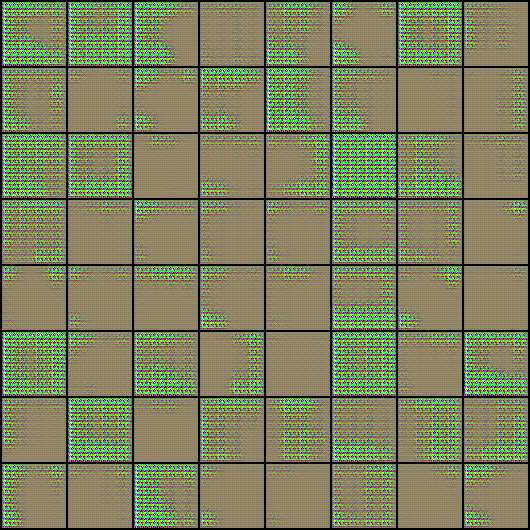

In [31]:
Image('./generated/generated-images-0001.png')

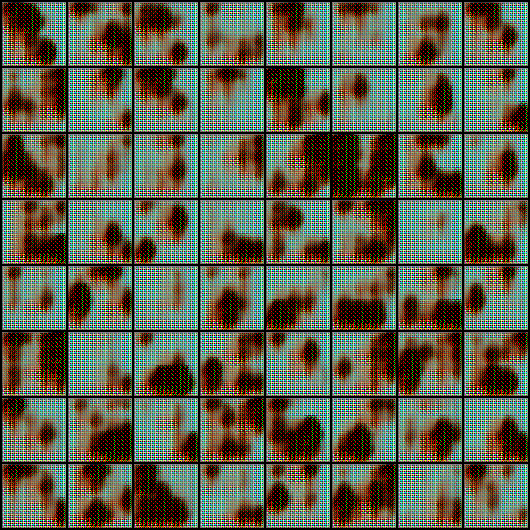

In [32]:
Image('./generated/generated-images-0010.png')

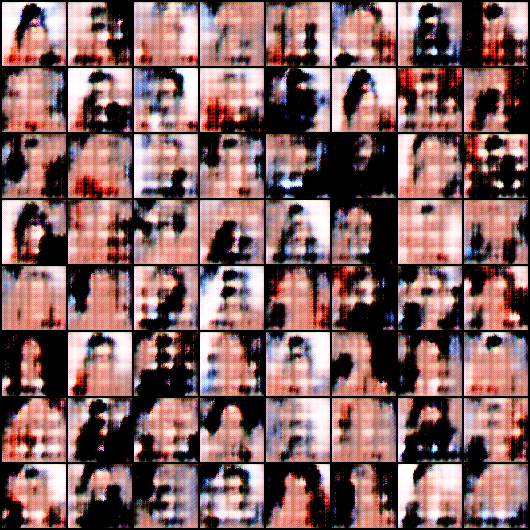

In [33]:
Image('./generated/generated-images-0050.png')

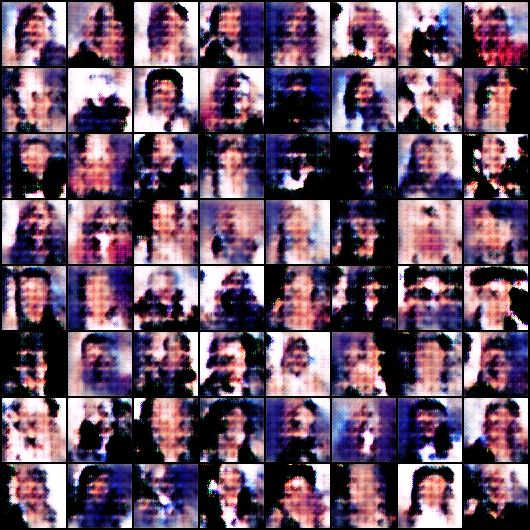

In [34]:
Image('./generated/generated-images-0100.png')

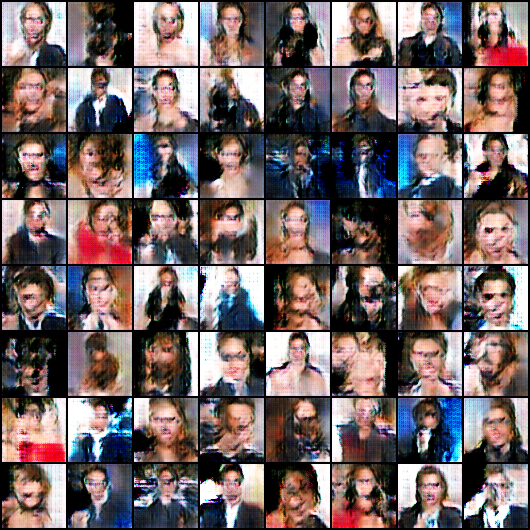

In [35]:
Image('./generated/generated-images-0200.png')

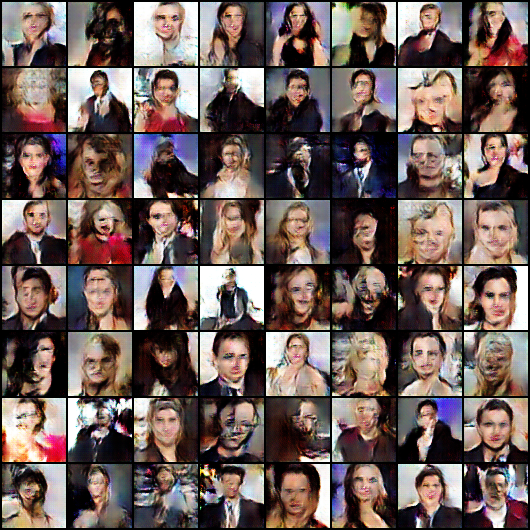

In [36]:
Image('./generated/generated-images-0300.png')

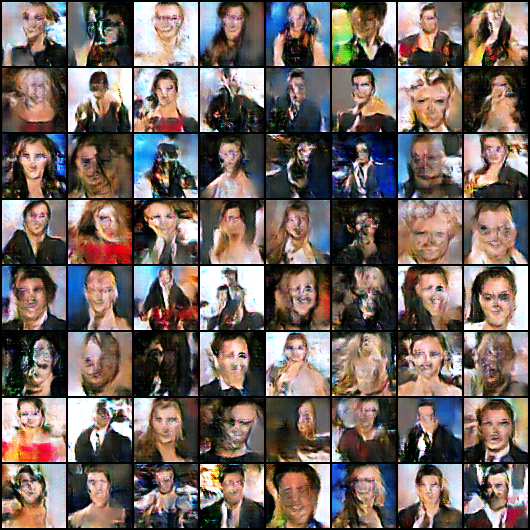

In [40]:
Image('./generated/generated-images-0350.png')

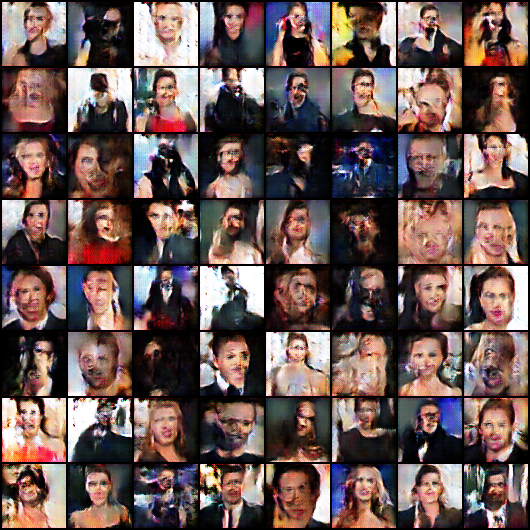

In [41]:
Image('./generated/generated-images-0400.png')

## Combining the sample images and making video using OpenCV.


In [44]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


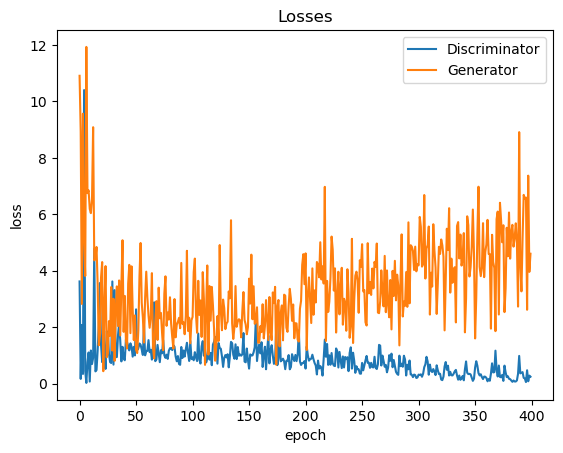

In [45]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

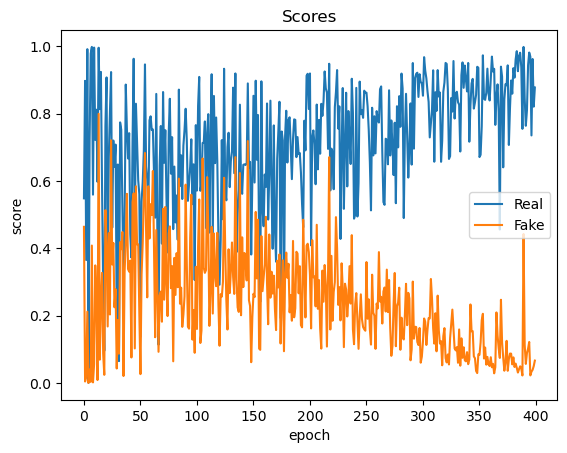

In [46]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');